In [6]:
# Install libraries
!pip install pybaseball
!pip install -U scikit-learn




[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [7]:
from pybaseball import batting_stats
import pandas as pd

# Define the seasons you want
years = [2022, 2023, 2024]

# Download and combine data for all years
dfs = []
for year in years:
    df_year = batting_stats(year, qual=100)
    df_year["season"] = year
    dfs.append(df_year)

# Combine into one DataFrame
df_all = pd.concat(dfs, ignore_index=True)

# Preview and save
print(df_all.shape)
print(df_all.head())

(1385, 321)
    IDfg  Season              Name Team  Age    G   AB   PA    H   1B  ...  \
0  15640    2022       Aaron Judge  NYY   30  157  570  696  177   87  ...   
1   9777    2022     Nolan Arenado  STL   31  148  557  620  163   90  ...   
2  11493    2022     Manny Machado  SDP   29  150  578  644  172  102  ...   
3   5417    2022       Jose Altuve  HOU   32  141  527  604  158   91  ...   
4   9218    2022  Paul Goldschmidt  STL   34  151  561  651  178  102  ...   

   HardHit  HardHit%  Events  CStr%   CSW%    xBA   xSLG  xwOBA  L-WAR  season  
0      247     0.611     404  0.169  0.287  0.305  0.706  0.463   11.4    2022  
1      190     0.389     489  0.155  0.241  0.266  0.445  0.339    7.1    2022  
2      219     0.490     447  0.126  0.243  0.264  0.447  0.338    7.4    2022  
3      131     0.297     441  0.173  0.240  0.269  0.440  0.354    6.6    2022  
4      201     0.472     426  0.196  0.295  0.261  0.482  0.367    7.0    2022  

[5 rows x 321 columns]


Kept 25 columns. Missing: none
(1385, 25)
      id              name team  season   pa    avg  babip  bb_rate  k_rate  \
0  15640       Aaron Judge  NYY    2022  696  0.311  0.340    0.159   0.251   
1   9777     Nolan Arenado  STL    2022  620  0.293  0.290    0.084   0.116   
2  11493     Manny Machado  SDP    2022  644  0.298  0.337    0.098   0.207   
3   5417       Jose Altuve  HOU    2022  604  0.300  0.315    0.109   0.144   
4   9218  Paul Goldschmidt  STL    2022  651  0.317  0.368    0.121   0.217   

   sprint_speed  ...  zcontact  contact     ld     gb     fb   iffb  hr_fb  \
0           4.0  ...     0.852    0.722  0.193  0.373  0.435  0.046  0.356   
1           2.6  ...     0.908    0.823  0.204  0.297  0.499  0.168  0.123   
2           4.3  ...     0.856    0.768  0.206  0.378  0.416  0.151  0.172   
3           5.0  ...     0.910    0.846  0.204  0.410  0.387  0.120  0.168   
4           3.6  ...     0.818    0.763  0.189  0.403  0.408  0.104  0.202   

    pull   opp

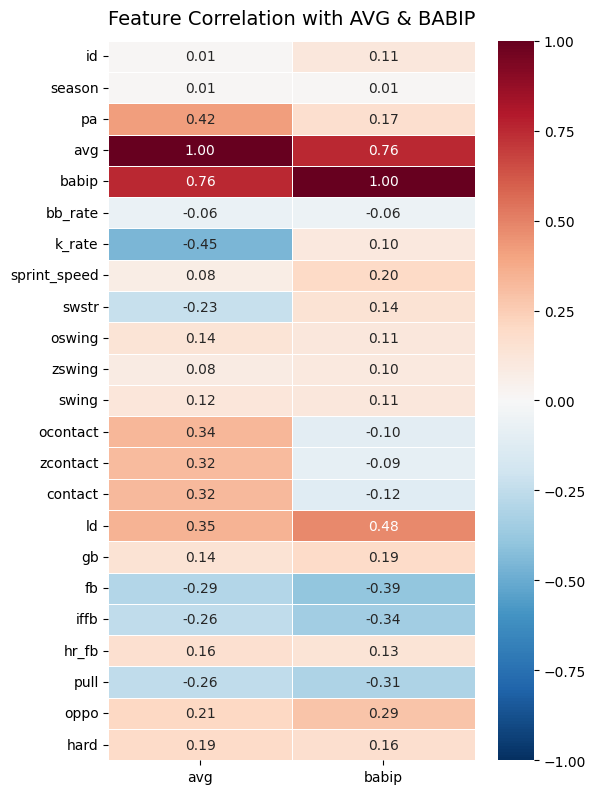


Top 10 correlated features with AVG:
avg         1.000000
babip       0.756286
pa          0.415410
ld          0.349132
ocontact    0.335655
contact     0.322088
zcontact    0.315147
oppo        0.210543
hard        0.188776
hr_fb       0.162291
Name: avg, dtype: float64

Top 10 correlated features with BABIP:
babip           1.000000
avg             0.756286
ld              0.477229
oppo            0.288332
sprint_speed    0.196965
gb              0.187817
pa              0.165157
hard            0.164998
swstr           0.143972
hr_fb           0.132995
Name: babip, dtype: float64


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# columns we want to consider
cols = [
    'IDfg','Name','Team','Season','PA','AVG','BABIP','BB%','K%','Spd',
    'SwStr%','O-Swing%','Z-Swing%','Swing%','O-Contact%','Z-Contact%','Contact%',
    'LD%','GB%','FB%','IFFB%','HR/FB','Pull%','Oppo%','Hard%'
]

# keep only the intersection
available = [c for c in cols if c in df_all.columns]
missing = [c for c in cols if c not in df_all.columns]

df_focus = df_all[available].copy()
print(f"Kept {len(available)} columns. Missing: {missing if missing else 'none'}")

# standardize column names to snake_case
rename_map = {
    'IDfg': 'id', 'Name': 'name', 'Team': 'team', 'Season': 'season', 'PA': 'pa',
    'AVG': 'avg', 'BABIP': 'babip', 'BB%': 'bb_rate', 'K%': 'k_rate', 'Spd': 'sprint_speed',
    'SwStr%': 'swstr', 'O-Swing%': 'oswing', 'Z-Swing%': 'zswing', 'Swing%': 'swing',
    'O-Contact%': 'ocontact', 'Z-Contact%': 'zcontact', 'Contact%': 'contact',
    'LD%': 'ld', 'GB%': 'gb', 'FB%': 'fb', 'IFFB%': 'iffb', 'HR/FB': 'hr_fb',
    'Pull%': 'pull', 'Oppo%': 'oppo', 'Hard%': 'hard'
}
df_focus.rename(columns=rename_map, inplace=True)

# Preview and save
print(df_focus.shape)
print(df_focus.head())

# filter to meaningful seasons
MIN_PA = 200
df_corr = df_focus[df_focus['pa'] >= MIN_PA].copy()

# select numeric columns (ignore id/name/team)
num_cols = df_corr.select_dtypes(include=[np.number]).columns.tolist()

# compute correlation matrix
corr = df_corr[num_cols].corr()

# extract only features vs AVG and BABIP
targets = ['avg', 'babip']
corr_targets = corr[targets].copy()

# plot
plt.figure(figsize=(6, max(4, 0.35 * len(corr_targets))))
sns.heatmap(corr_targets, cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            linewidths=0.5, annot=True, fmt=".2f")
plt.title("Feature Correlation with AVG & BABIP", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

# optional: quick sorted correlations to inspect top signals
print("\nTop 10 correlated features with AVG:")
print(corr_targets['avg'].sort_values(ascending=False).head(10))
print("\nTop 10 correlated features with BABIP:")
print(corr_targets['babip'].sort_values(ascending=False).head(10))

In [9]:
# =============================================================================
# ORION: DATA CLEANING AND PROCESSING (STEP 2)
# =============================================================================

import pandas as pd
import numpy as np

print("STEP 2: CLEAN AND PROCESS DATA")
print("=" * 40)

# Start with the focused dataset
df_clean = df_focus.copy()
print(f"Starting: {df_clean.shape}")

# 1. EXPLORATORY DATA ANALYSIS
print("\n1. Data Info:")
print(f"Shape: {df_clean.shape}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")
print(f"Data types: {df_clean.dtypes.value_counts().to_dict()}")

# 2. REMOVE COLUMNS WITH LOTS OF MISSING DATA (>50%)
missing_pct = (df_clean.isnull().sum() / len(df_clean)) * 100
cols_to_drop = missing_pct[missing_pct > 50].index.tolist()
if cols_to_drop:
    df_clean = df_clean.drop(columns=cols_to_drop)
    print(f"\n2. Removed {len(cols_to_drop)} columns with >50% missing data")

# 3. REMOVE DUPLICATE PLAYERS (keep highest PA)
duplicates_before = df_clean.duplicated(subset=['name', 'season']).sum()
df_clean = df_clean.sort_values('pa', ascending=False).drop_duplicates(subset=['name', 'season'], keep='first')
print(f"\n3. Removed {duplicates_before} duplicate player-season combinations")

# 4. HANDLE TEXT DATA
# Convert team to dummy variables
if 'team' in df_clean.columns:
    team_dummies = pd.get_dummies(df_clean['team'], prefix='team')
    df_clean = pd.concat([df_clean, team_dummies], axis=1).drop(columns=['team'])

# Convert name to numeric ID (simple approach without sklearn)
if 'name' in df_clean.columns:
    unique_names = df_clean['name'].unique()
    name_to_id = {name: idx for idx, name in enumerate(unique_names)}
    df_clean['player_id'] = df_clean['name'].map(name_to_id)
    df_clean = df_clean.drop(columns=['name'])

print(f"\n4. Handled text data: {df_clean.shape}")

# 5. CONVERT DATA TYPES
for col in df_clean.columns:
    if col in ['id', 'season', 'player_id']:
        df_clean[col] = df_clean[col].astype('int32')
    else:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# 6. REMOVE OUTLIERS (conservative 3*IQR rule)
key_cols = ['avg', 'babip', 'pa', 'bb_rate', 'k_rate', 'sprint_speed']
initial_rows = len(df_clean)

for col in key_cols:
    if col in df_clean.columns:
        Q1, Q3 = df_clean[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1
        bounds = (Q1 - 3*IQR, Q3 + 3*IQR)
        df_clean = df_clean[(df_clean[col] >= bounds[0]) & (df_clean[col] <= bounds[1])]

print(f"\n5-6. Removed {initial_rows - len(df_clean)} outliers, converted data types")

# 7. FINAL CLEANUP
# Fill remaining missing values
df_clean = df_clean.fillna(df_clean.median(numeric_only=True))

print(f"\n7. Final dataset: {df_clean.shape}")
print(f"Missing values: {df_clean.isnull().sum().sum()}")

# Save cleaned data
df_clean.to_csv("cleaned_batting_data.csv", index=False)
print(f"\nCleaned data saved to: cleaned_batting_data.csv")
print("DATA CLEANING COMPLETE!")


STEP 2: CLEAN AND PROCESS DATA
Starting: (1385, 25)

1. Data Info:
Shape: (1385, 25)
Missing values: 0
Data types: {dtype('float64'): 20, dtype('int64'): 3, dtype('O'): 2}

3. Removed 0 duplicate player-season combinations

4. Handled text data: (1385, 55)

5-6. Removed 0 outliers, converted data types

7. Final dataset: (1385, 55)
Missing values: 0

Cleaned data saved to: cleaned_batting_data.csv
DATA CLEANING COMPLETE!


In [10]:
# Bell Train/Test Splitting
# Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
import pandas as pd
from sklearn.model_selection import train_test_split

# Load proccessed data
df = pd.read_csv('cleaned_batting_data.csv')

# Set X and Y
X = df.drop(columns=['avg'])
Y = df["avg"]

# Split traning and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42
)

# Save datasets as csv
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
Y_train.to_csv('Y_train.csv', index=False)
Y_test.to_csv('Y_test.csv', index=False)



In [ ]:
# Linear Regression Model Training

In [ ]:
# Random Forest Model Training

In [ ]:
# Mixed effects Model Training